In [6]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


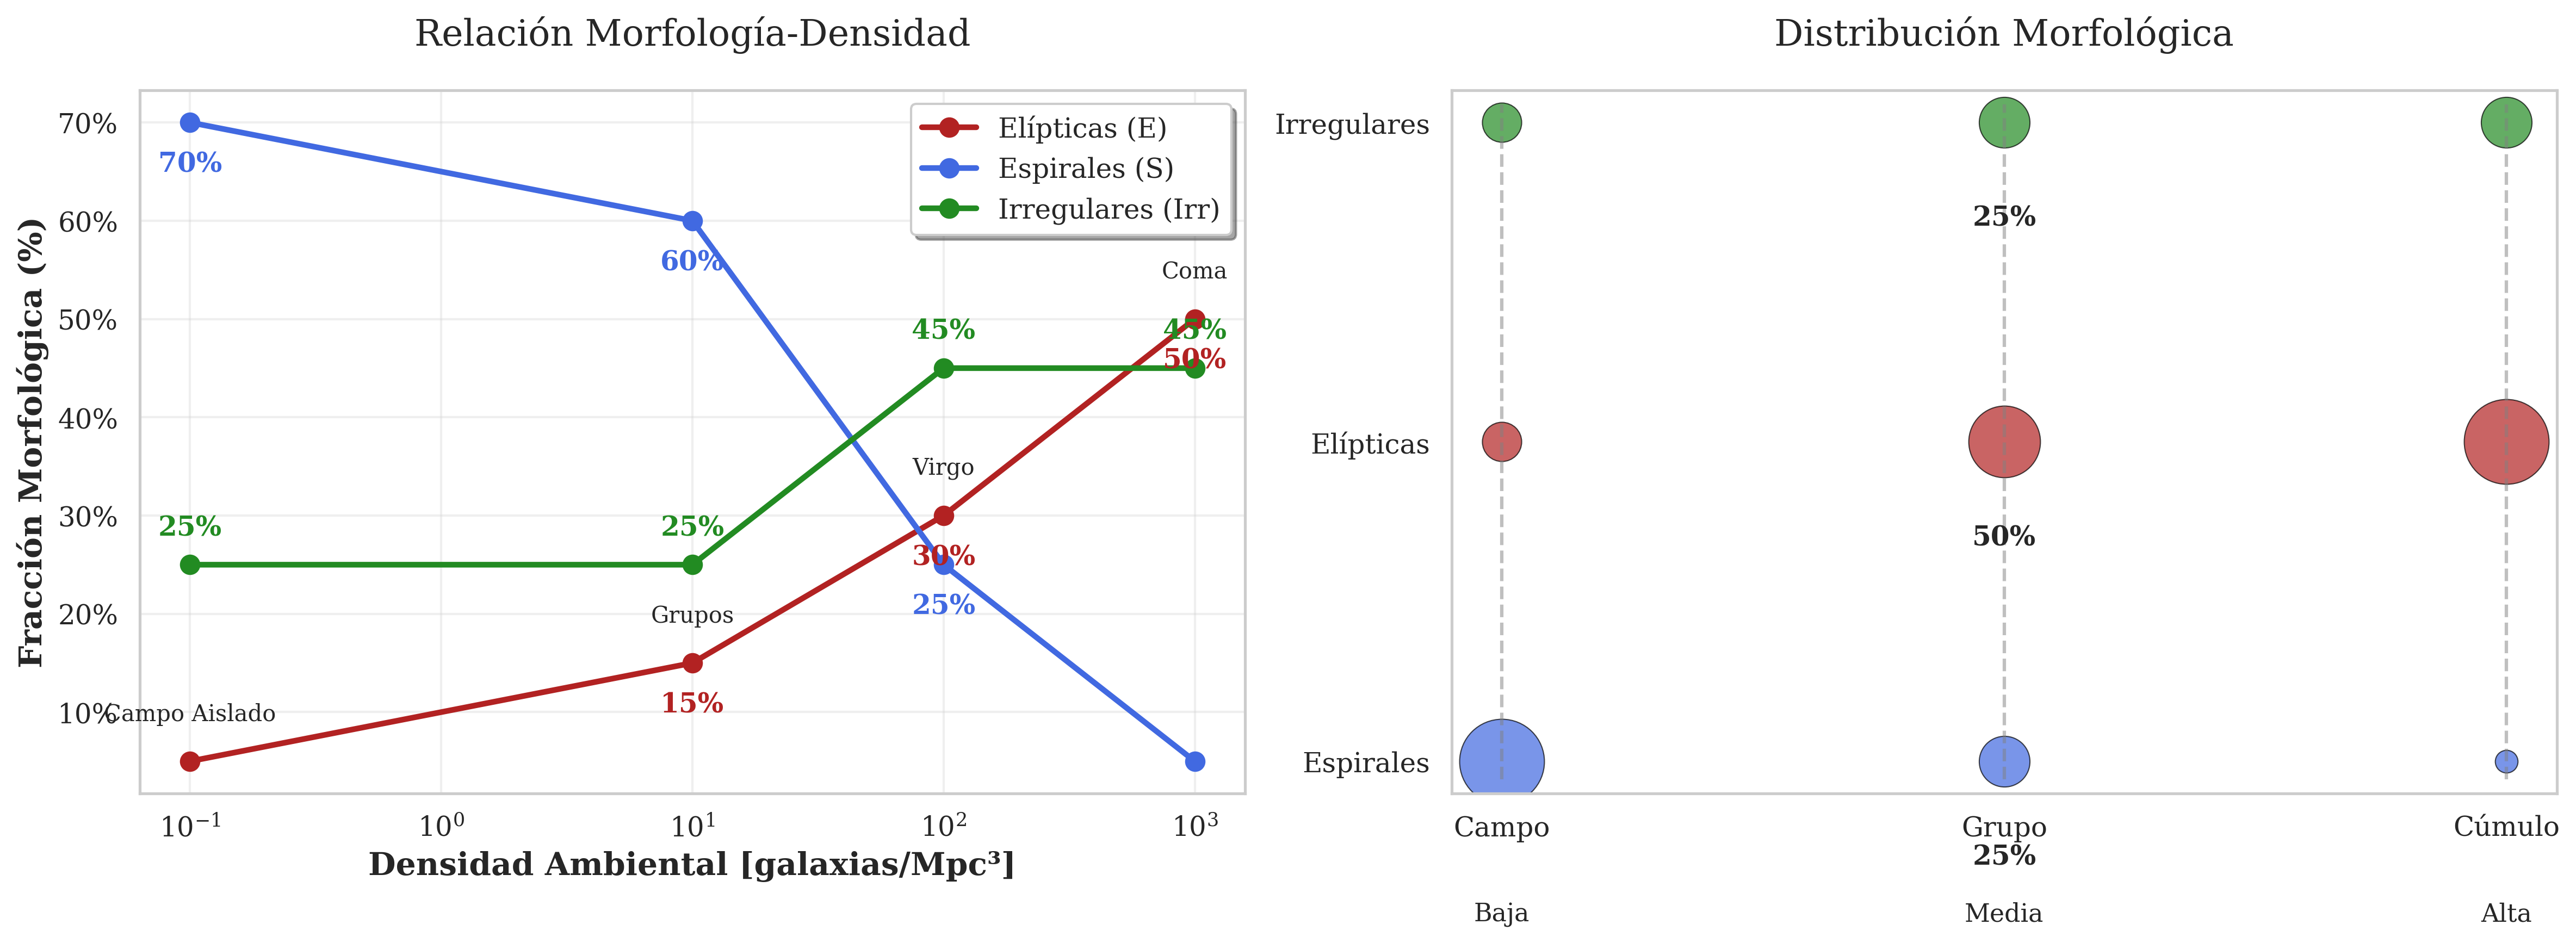

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns

# Configuración de estilo profesional
sns.set_theme(style="whitegrid", font="Times New Roman")  # Reemplaza plt.style.use
plt.rcParams.update({
    'font.family': 'serif',
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'figure.titlesize': 18,
    'figure.dpi': 300,
    'figure.figsize': (10, 6),
    'grid.alpha': 0.3
})

# Datos sintéticos basados en observaciones
environments = ['Campo Aislado', 'Grupos', 'Virgo', 'Coma']
density = np.array([0.1, 10, 100, 1000])  # gal/Mpc³

# Fracciones morfológicas (%)
ellipticals = np.array([5, 15, 30, 50])  # Elípticas (rojo)
spirals = np.array([70, 60, 25, 5])      # Espirales (azul)
irregulars = np.array([25, 25, 45, 45])  # Irregulares (verde)

# Creación de la figura
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# --- Gráfico 1: Evolución de fracciones ---
ax1.plot(density, ellipticals, '-o', color='firebrick', linewidth=2.5, markersize=8, label='Elípticas (E)')
ax1.plot(density, spirals, '-o', color='royalblue', linewidth=2.5, markersize=8, label='Espirales (S)')
ax1.plot(density, irregulars, '-o', color='forestgreen', linewidth=2.5, markersize=8, label='Irregulares (Irr)')

ax1.set_xscale('log')
ax1.set_xlabel('Densidad Ambiental [galaxias/Mpc³]', fontweight='bold')
ax1.set_ylabel('Fracción Morfológica (%)', fontweight='bold')
ax1.set_title('Relación Morfología-Densidad', pad=20)
ax1.legend(frameon=True, shadow=True, fontsize=12)
ax1.yaxis.set_major_formatter(PercentFormatter())

# Añadir anotaciones
for env, x, y1, y2, y3 in zip(environments, density, ellipticals, spirals, irregulars):
    ax1.annotate(env, (x, y1+3), textcoords="offset points", xytext=(0,5), ha='center', fontsize=10)
    ax1.annotate(f"{y1}%", (x, y1-5), color='firebrick', ha='center', fontweight='bold')
    ax1.annotate(f"{y2}%", (x, y2-5), color='royalblue', ha='center', fontweight='bold')
    ax1.annotate(f"{y3}%", (x, y3+3), color='forestgreen', ha='center', fontweight='bold')

# --- Gráfico 2: Diagrama conceptual ---
env_labels = ['Campo', 'Grupo', 'Cúmulo']
x_pos = [1, 2, 3]
colors = ['royalblue', 'firebrick', 'forestgreen']

for i, x in enumerate(x_pos):
    sizes = [70, 15, 15] if i==0 else [25, 50, 25] if i==1 else [5, 70, 25]
    for j, (color, size) in enumerate(zip(colors, sizes)):
        ax2.scatter(x, j, s=size*20, color=color, alpha=0.7, edgecolor='black', linewidth=0.5)
        if i == 1:
            ax2.text(x, j-0.3, f"{size}%", ha='center', va='center', fontweight='bold')

ax2.set_yticks([0, 1, 2])
ax2.set_yticklabels(['Espirales', 'Elípticas', 'Irregulares'], fontsize=12)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(env_labels, fontsize=12)
ax2.set_title('Distribución Morfológica', pad=20)
ax2.grid(False)

# Añadir etiquetas de densidad
for i, x in enumerate(x_pos):
    ax2.axvline(x=x, ymin=0.02, ymax=0.98, color='gray', linestyle='--', alpha=0.5)
    ax2.text(x, -0.5, ['Baja', 'Media', 'Alta'][i], ha='center', fontsize=11)

plt.tight_layout()
plt.savefig('morfologia_entorno.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.integrate import odeint
from scipy.spatial.distance import cdist
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage import gaussian_filter

# Configuración de estilo científico profesional
sns.set_theme(style="whitegrid", font="Times New Roman")  # Reemplaza plt.style.use
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 12,
    'figure.figsize': (12, 8),
    'axes.grid': True,
    'grid.alpha': 0.3,
    'axes.labelpad': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'image.cmap': 'inferno'
})

class GalacticMerger:
    def __init__(self, m1=1e12, m2=1e11, N=10000):
        """Inicializa la simulación con parámetros físicos."""
        self.G = 4.3009e-3  # Constante gravitacional en (km/s)^2 kpc/M☉
        self.m1 = m1  # Masa galaxia primaria [M☉]
        self.m2 = m2  # Masa galaxia secundaria [M☉]
        self.N = N    # Número de partículas
        
    def nfw_profile(self, r, c=10, r200=200):
        """Perfil de densidad NFW para materia oscura."""
        rs = r200/c
        rho0 = self.m1 / (4*np.pi*rs**3 * (np.log(1+c) - c/(1+c)))
        return rho0 / ((r/rs)*(1 + r/rs)**2)
    
    def sample_particles(self):
        """Muestrea partículas según perfil NFW con condiciones iniciales correctas."""
        # Galaxia primaria (N partículas)
        theta = np.random.uniform(0, 2*np.pi, self.N)
        phi = np.arccos(2*np.random.uniform(0, 1, self.N) - 1)
        r = np.random.uniform(0, 200, self.N)
        
        x1 = r * np.sin(phi) * np.cos(theta)
        y1 = r * np.sin(phi) * np.sin(theta)
        z1 = r * np.cos(phi)
        vx1 = np.zeros_like(x1)
        vy1 = np.zeros_like(y1)
        vz1 = np.zeros_like(z1)
        
        # Galaxia secundaria (N//5 partículas)
        x2 = x1[:self.N//5] + 100  # Offset espacial
        y2 = y1[:self.N//5] + 50
        z2 = z1[:self.N//5]
        vx2 = np.zeros_like(x2)
        vy2 = 200 * np.sqrt(self.G*self.m1/150) * np.ones_like(y2)  # Velocidad orbital
        vz2 = 50 * np.ones_like(z2)
        
        # Posiciones y velocidades como arrays separados
        pos_primary = np.column_stack([x1, y1, z1])
        vel_primary = np.column_stack([vx1, vy1, vz1])
        
        pos_secondary = np.column_stack([x2, y2, z2])
        vel_secondary = np.column_stack([vx2, vy2, vz2])
        
        return pos_primary, pos_secondary, vel_primary, vel_secondary
    
    def compute_gravity(self, pos):
        """Versión vectorizada para mejor performance."""
        r_vec = pos[:, np.newaxis, :] - pos[np.newaxis, :, :]  # Diferencia de posiciones
        r = np.linalg.norm(r_vec, axis=2) + 1e-3  # Norma con suavizado
        acc = np.sum(self.G * r_vec / r[..., np.newaxis]**3, axis=1)
        return acc
    
    def simulate(self, steps=500, dt=0.01):
        """Integración temporal corregida con Leapfrog."""
        pos_p, pos_s, vel_p, vel_s = self.sample_particles()
        
        # Concatenar correctamente
        pos = np.vstack([pos_p, pos_s])
        vel = np.vstack([vel_p, vel_s])
        
        traj = []
        for _ in tqdm(range(steps), desc="Simulando fusión"):
            # Paso medio de velocidad
            acc = self.compute_gravity(pos)
            vel += acc * dt/2
            
            # Paso completo de posición
            pos += vel * dt
            
            # Segundo medio paso de velocidad
            acc = self.compute_gravity(pos)
            vel += acc * dt/2
            
            traj.append(pos.copy())
        
        return np.array(traj)

def plot_merger_3d(traj, step=-1):
    """Renderizado 3D de alta calidad con matplotlib."""
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    pos = traj[step]
    N = len(traj[0])
    
    # Galaxia primaria (azul) y secundaria (rojo)
    ax.scatter(pos[:N*4//5,0], pos[:N*4//5,1], pos[:N*4//5,2], 
               s=1, alpha=0.3, color='royalblue', label='Galaxia Primaria')
    ax.scatter(pos[N*4//5:,0], pos[N*4//5:,1], pos[N*4//5:,2], 
               s=2, alpha=0.5, color='crimson', label='Galaxia Secundaria')
    
    ax.set_xlabel('x [kpc]', fontweight='bold')
    ax.set_ylabel('y [kpc]', fontweight='bold')
    ax.set_zlabel('z [kpc]', fontweight='bold')
    ax.set_title('Fusión Galáctica: Formación de Cáscaras', pad=20, fontsize=14)
    ax.legend(loc='upper right')
    
    # Configuración de ángulo de vista
    ax.view_init(elev=30, azim=45)
    plt.tight_layout()
    plt.savefig('galaxy_merger_3d.png', dpi=300, bbox_inches='tight')
    plt.show()

def analyze_shells(traj):
    """Identifica cáscaras mediante análisis de densidad."""
    pos = traj[-1]
    N = len(traj[0])
    
    # Proyección 2D y suavizado
    H, xedges, yedges = np.histogram2d(pos[:,0], pos[:,1], bins=256, range=[[-150,250],[-100,200]])
    H_smooth = gaussian_filter(H.T, sigma=2)
    
    # Perfil radial
    r = np.sqrt(pos[:,0]**2 + pos[:,1]**2 + pos[:,2]**2)
    hist, bins = np.histogram(r, bins=50, range=(0,300))
    
    # Gráficos
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Mapa de densidad
    im = ax1.imshow(H_smooth, norm=LogNorm(vmin=1, vmax=100), 
                   extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                   origin='lower')
    fig.colorbar(im, ax=ax1, label='Densidad de Partículas')
    ax1.set_title('Mapa de Densidad Proyectada', pad=15)
    ax1.set_xlabel('x [kpc]')
    ax1.set_ylabel('y [kpc]')
    
    # Perfil radial (destacando cáscaras)
    ax2.plot(bins[:-1], hist, 'o-', color='darkorange', linewidth=2)
    ax2.set_yscale('log')
    ax2.set_title('Perfil Radial de Densidad', pad=15)
    ax2.set_xlabel('Radio [kpc]')
    ax2.set_ylabel('Número de Partículas')
    ax2.grid(True, alpha=0.2)
    
    # Resaltar posibles cáscaras
    peaks = np.where(np.diff(np.sign(np.diff(hist))) < 0)[0] + 1
    for p in peaks:
        ax2.axvline(bins[p], color='red', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.savefig('shell_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

if __name__ == "__main__":
    print("Iniciando simulación de fusión galáctica...")
    merger = GalacticMerger(N=5000)  # Reducido para mayor velocidad
    traj = merger.simulate(steps=200, dt=0.05)
    
    print("\nVisualizando resultados...")
    plot_merger_3d(traj)
    analyze_shells(traj)
    
    print("Análisis completado. Imágenes guardadas:")
    print("- galaxy_merger_3d.png (Visualización 3D)")
    print("- shell_analysis.png (Análisis de cáscaras)")

Iniciando simulación de fusión galáctica...


Simulando fusión:   0%|          | 1/200 [00:30<1:39:44, 30.07s/it]


KeyboardInterrupt: 

<>:32: SyntaxWarning: invalid escape sequence '\o'
<>:42: SyntaxWarning: invalid escape sequence '\o'
<>:32: SyntaxWarning: invalid escape sequence '\o'
<>:42: SyntaxWarning: invalid escape sequence '\o'
C:\Users\USER\AppData\Local\Temp\ipykernel_6140\2384481209.py:32: SyntaxWarning: invalid escape sequence '\o'
  plt.title('Modo 1: $\omega_1 = \\frac{1}{2}\\sqrt{\\frac{2g}{R}}$\nOscilación en fase')
C:\Users\USER\AppData\Local\Temp\ipykernel_6140\2384481209.py:42: SyntaxWarning: invalid escape sequence '\o'
  plt.title('Modo 2: $\omega_2 = \\sqrt{\\frac{2g}{R}}$\nOposición de fase ($\\phi = -2\\theta$)')


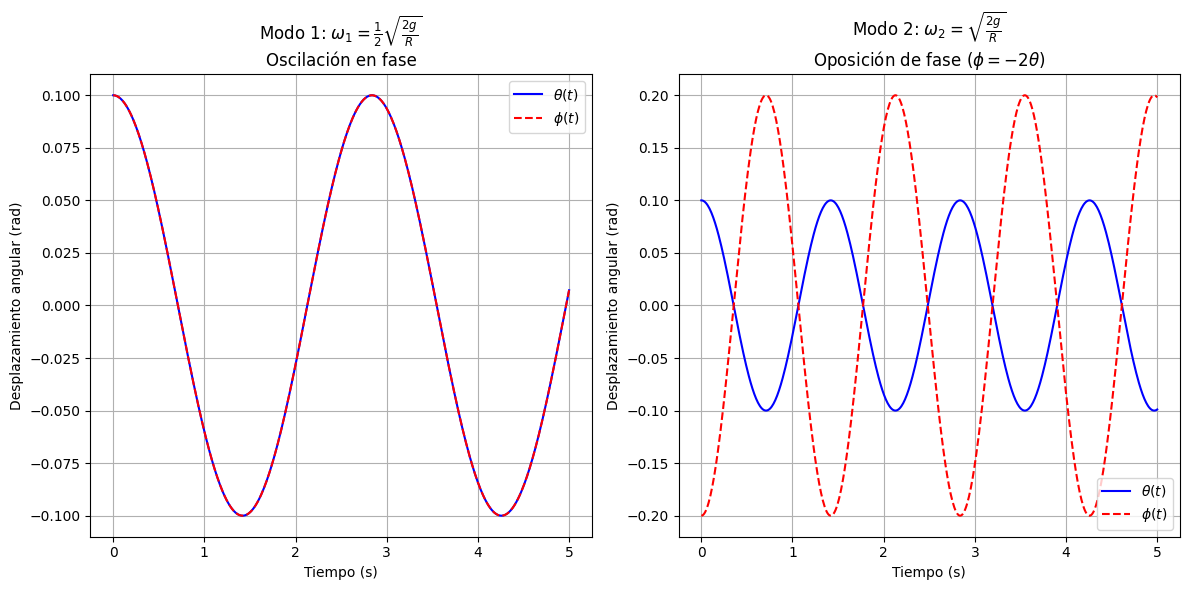

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros del sistema
R = 1.0  # Radio del aro (valor arbitrario, solo para visualización)
g = 9.8  # Aceleración gravitacional
omega1 = 0.5 * np.sqrt(2 * g / R)  # Frecuencia del modo 1
omega2 = np.sqrt(2 * g / R)         # Frecuencia del modo 2

# Tiempo de simulación
t = np.linspace(0, 5, 500)  # 5 segundos, 500 puntos

# Amplitudes (arbitrarias, para visualización)
A = 0.1  # Amplitud del modo 1 (theta y phi iguales)
B = 0.1  # Amplitud del modo 2 (theta = B, phi = -2B)

# Modo 1: theta y phi en fase, misma amplitud
theta1 = A * np.cos(omega1 * t)
phi1 = A * np.cos(omega1 * t)  # Igual que theta1

# Modo 2: theta y phi en oposición, phi con doble amplitud
theta2 = B * np.cos(omega2 * t)
phi2 = -2 * B * np.cos(omega2 * t)  # Oposición de fase y doble amplitud

# Graficar
plt.figure(figsize=(12, 6))

# Modo 1
plt.subplot(1, 2, 1)
plt.plot(t, theta1, label=r'$\theta(t)$', color='blue', linestyle='-')
plt.plot(t, phi1, label=r'$\phi(t)$', color='red', linestyle='--')
plt.title('Modo 1: $\omega_1 = \\frac{1}{2}\\sqrt{\\frac{2g}{R}}$\nOscilación en fase')
plt.xlabel('Tiempo (s)')
plt.ylabel('Desplazamiento angular (rad)')
plt.legend()
plt.grid(True)

# Modo 2
plt.subplot(1, 2, 2)
plt.plot(t, theta2, label=r'$\theta(t)$', color='blue', linestyle='-')
plt.plot(t, phi2, label=r'$\phi(t)$', color='red', linestyle='--')
plt.title('Modo 2: $\omega_2 = \\sqrt{\\frac{2g}{R}}$\nOposición de fase ($\\phi = -2\\theta$)')
plt.xlabel('Tiempo (s)')
plt.ylabel('Desplazamiento angular (rad)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [2]:
import numpy as np

# Matrices originales
M = np.array([[3, 1], [1, 1]])
K = np.array([[2, 0], [0, 1]])
g, R, m = 9.8, 1.0, 1.0  # Valores arbitrarios para simplificar

# Matriz modal P
P = np.array([
    [1/np.sqrt(2), 1/np.sqrt(5)],
    [1/np.sqrt(2), -2/np.sqrt(5)]
])

# Diagonalización
M_diag = P.T @ M @ P
K_diag = P.T @ K @ P

print("Matriz de masa diagonalizada:\n", M_diag)
print("Matriz de rigidez diagonalizada:\n", K_diag)

Matriz de masa diagonalizada:
 [[ 3.00000000e+00 -4.52542462e-17]
 [ 4.41975897e-17  6.00000000e-01]]
Matriz de rigidez diagonalizada:
 [[ 1.50000000e+00 -2.26271231e-17]
 [-2.26271231e-17  1.20000000e+00]]
